###################### Part 1 ##############################

Вселенная акций и идентификация коинтегрированных пар акций
Наш первый шаг — определить вселенную акций и определить пары с высокой
корреляцией. Очень важно, чтобы это было основано на экономических отношениях,
таких как компании со схожим бизнесом, иначе это может быть ложным. Я взял все
составляющие NSE-100, которые относятся к категории компаний «ФИНАНСОВЫЕ УСЛУГИ».
Это дает нам список из 25 компаний для начала. Однако мы отфильтровываем компании с
ежедневными ценовыми данными менее чем за 10 лет и оставляем только последние 15 акций.
Мы берем дневную цену закрытия для этих 15 акций и разбиваем фрейм данных на тестовую и
обучающую выборки. Это сделано для того, чтобы наше решение о выборе коинтегрированной пары
основывалось на наборе обучающих данных, а тестирование на исторических данных выполнялось с
использованием набора тестовых данных вне выборки. В качестве первого шага мы воспользуемся
коэффициентом корреляции Пирсона, чтобы получить общее представление о взаимосвязи между этими.
акциями, а затем поработаем над определением коинтегрированных акций с помощью функции coint
statsmodels.tsa.stattools coint, которая вернет p-значения коинтеграции. тест для каждой пары. Мы будем
хранить эти p-значения в массиве и визуализировать его как тепловую карту. Если p-значение ниже 0,05,
это означает, что мы можем отклонить нулевую гипотезу, и два временных ряда разных символов могут
быть коинтегрированы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

In [2]:
from statsmodels.regression.linear_model  import  OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#прочитать csv матаданные
nifty_meta = pd.read_csv('data/nifty_meta.csv')
nifty_meta.head(4)

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
2,Adani Transmission Ltd.,POWER,ADANITRANS,EQ,INE931S01010
3,Ambuja Cements Ltd.,CEMENT & CEMENT PRODUCTS,AMBUJACEM,EQ,INE079A01024


In [5]:
#получить список тикеров с отраслью, равной FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry == 'FINANCIAL SERVICES'].Symbol)
print(tickers)
print(len(tickers))

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'GICRE', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'IBULHSGFIN', 'INDUSINDBK', 'KOTAKBANK', 'L&TFH', 'PEL', 'PFC', 'PNB', 'SBILIFE', 'SRTRANSFIN', 'SBIN', 'NIACL']
25


In [6]:
# даты начала и окончания тестирования
fromdate = datetime.datetime(2010, 1, 1)
todate =datetime.datetime(2020, 6, 15)

In [7]:
# прочитать данные о ценах
prices = pd.read_csv('data/prices.csv',index_col=['ticker', 'date'], parse_dates=True)
prices.head(5)

open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934
         2010-01-06  204.000000  205.740005  198.509995  141.236801
         2010-01-07  199.289993  201.199997  197.820007  142.236725
         2010-01-08  200.600006  203.979996  199.270004  144.094727

In [8]:
# удалить тикеры, если у нас есть данные менее чем за 10 лет.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

In [9]:
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38580 entries, ('AXISBANK', Timestamp('2010-01-04 00:00:00')) to ('SRTRANSFIN', Timestamp('2020-06-15 00:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    38579 non-null  float64
 1   high    38579 non-null  float64
 2   low     38579 non-null  float64
 3   close   38579 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB


In [10]:
# окончательный список
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)

15
['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']


In [11]:
# распаковать и взять цену закрытия
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head(2)

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904


In [12]:
# разбить тестовый
train_close, test_close = train_test_split(close, test_size=0.5,shuffle=False)

In [13]:
# быстрый просмотр головы и хвоста поезда set
train_close.head(2).append(train_close.tail(2))

/tmp/ipykernel_48802/4092566699.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_close.head(2).append(train_close.tail(2))


ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904
2015-03-18,565.011414,1429.524780,1232.434326,373.762146,176.891403,746.211670,504.396698,281.529602,876.665283,668.962646,776.118347,101.667664,164.392944,277.530243,1108.600708
2015-03-19,547.805969,1404.615723,1244.039917,372.603363,171.310471,746.211670,499.013824,277.661316,855.263062,660.394348,777.710266,100.663200,157.955719,272.024109,1115.327637


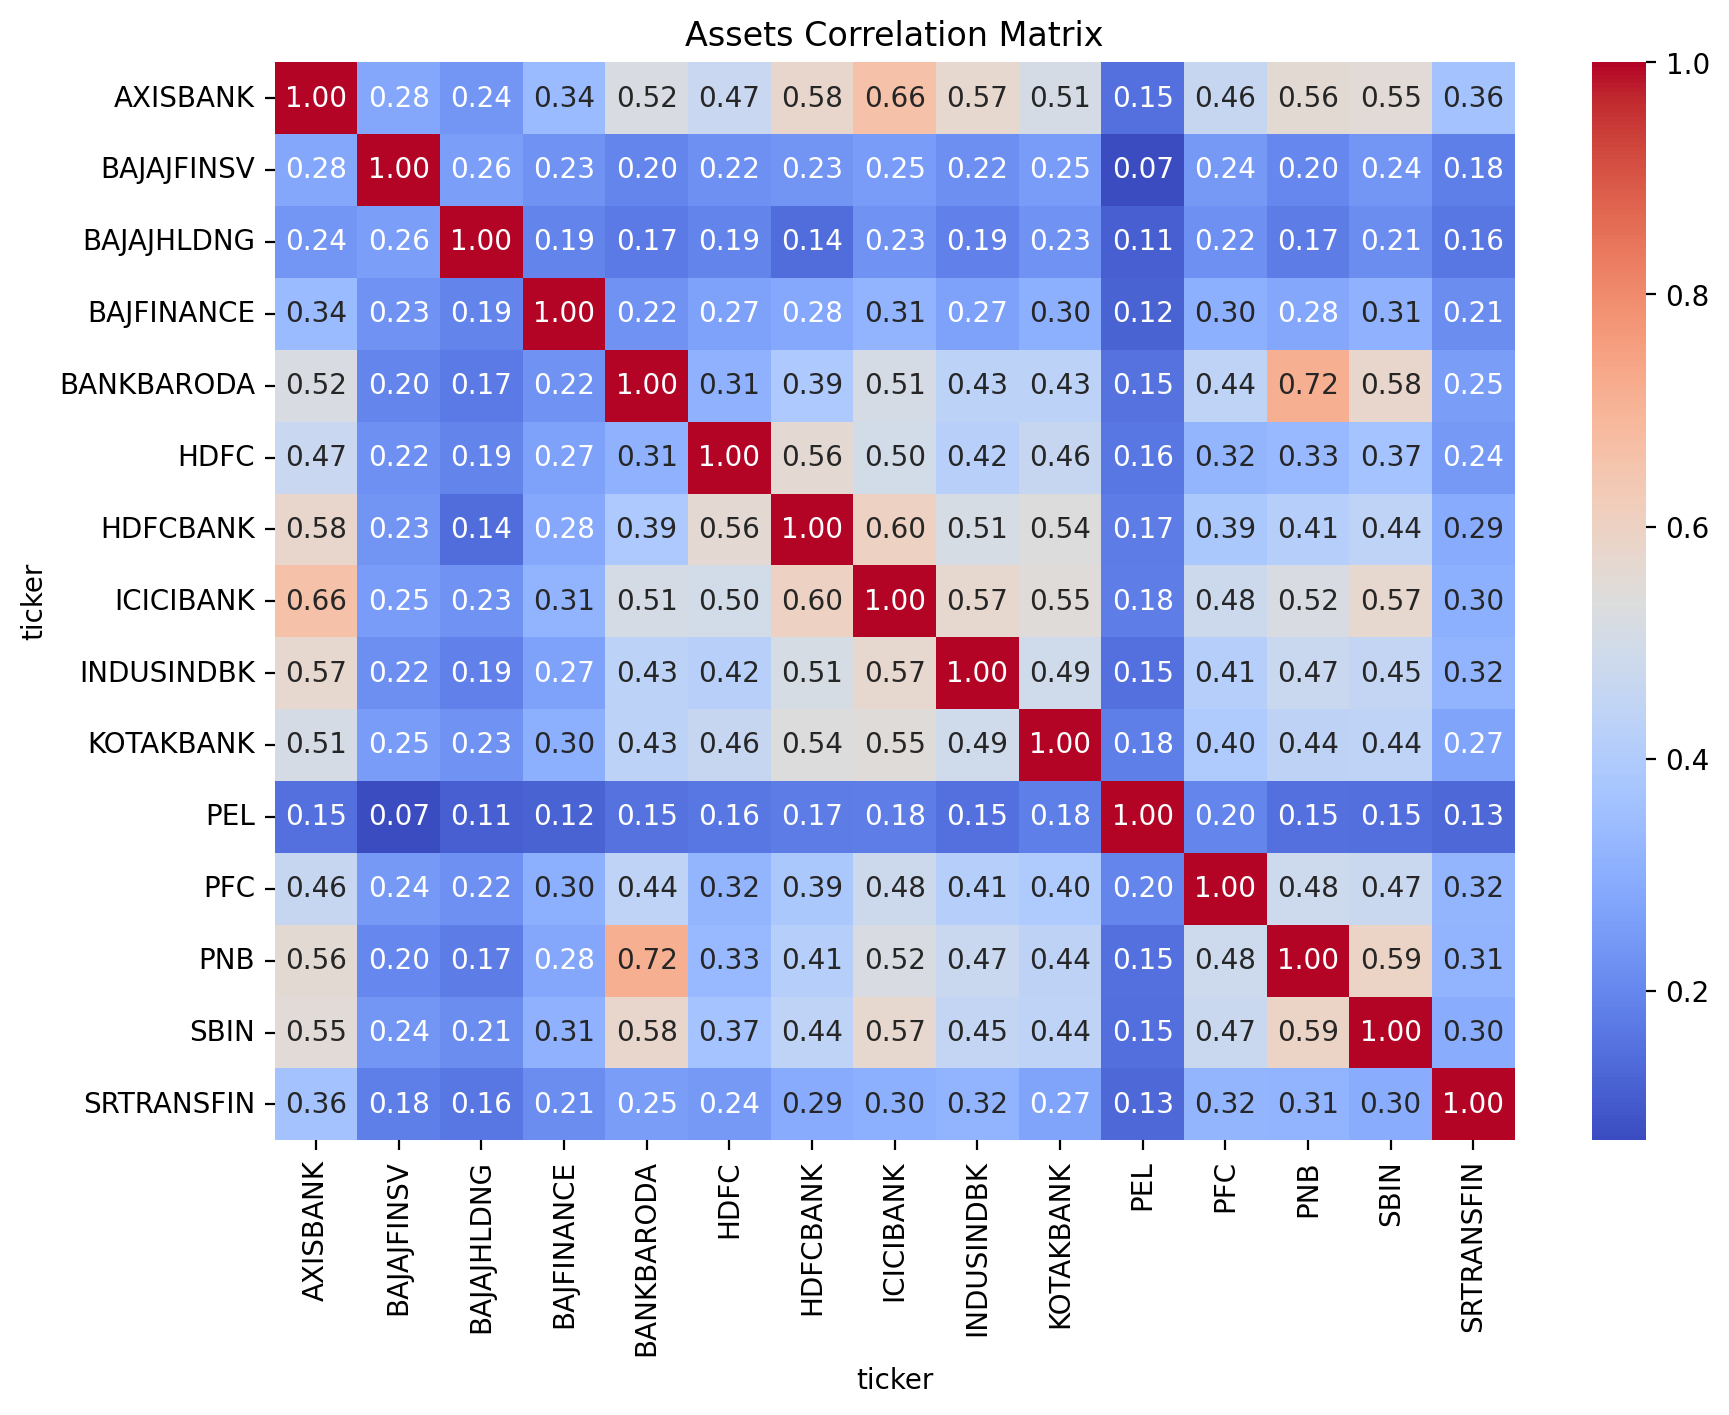

In [14]:
# Корреляция Пирсона, чтобы получить общее представление об отношениях
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax,
cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300)

Комментарий к коду:
1. Делаем необходимые импорты библиотек python.
2. Далее мы читаем nifty_meta.csv и создаем список тикеров, где индустрия
«ФИНАНСОВЫЕ УСЛУГИ» и установите даты начала и окончания.
3. Читайте ежедневные данные о ценах из Price.csv и удаляйте тикеры там, где их меньше .
данных за 10 лет.
4. Разделите фрейм данных ценообразования, чтобы иметь только ежедневные данные закрытия, и разделите их
по 50% на обучающие и тестовые наборы данных.
5. Постройте корреляцию Пирсона для ежедневной доходности, чтобы получить основное представление о
отношение.
6. Определите функцию find_cointegrated_pairs для поиска коинтегрированных пар и
соответствующие p-значения.
7. Постройте тепловую карту p-значений.

Коэффициент корреляции Пирсона варьируется от +1 до -1 и является линейной мерой
связь между двумя переменными. Значение +1 указывает на сильную положительную
корреляцию, ноль указывает на отсутствие связи, а -1 указывает на сильную
отрицательную связь. На приведенной выше тепловой карте видно, что есть несколько пар с
сильной положительной корреляцией.

In [15]:
# функция для поиска коинтегрированных
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOTAKBANK'), ('INDUSINDBK', 'PEL'), ('KOTAKBANK', 'PEL'), ('PEL', 'SBIN')]


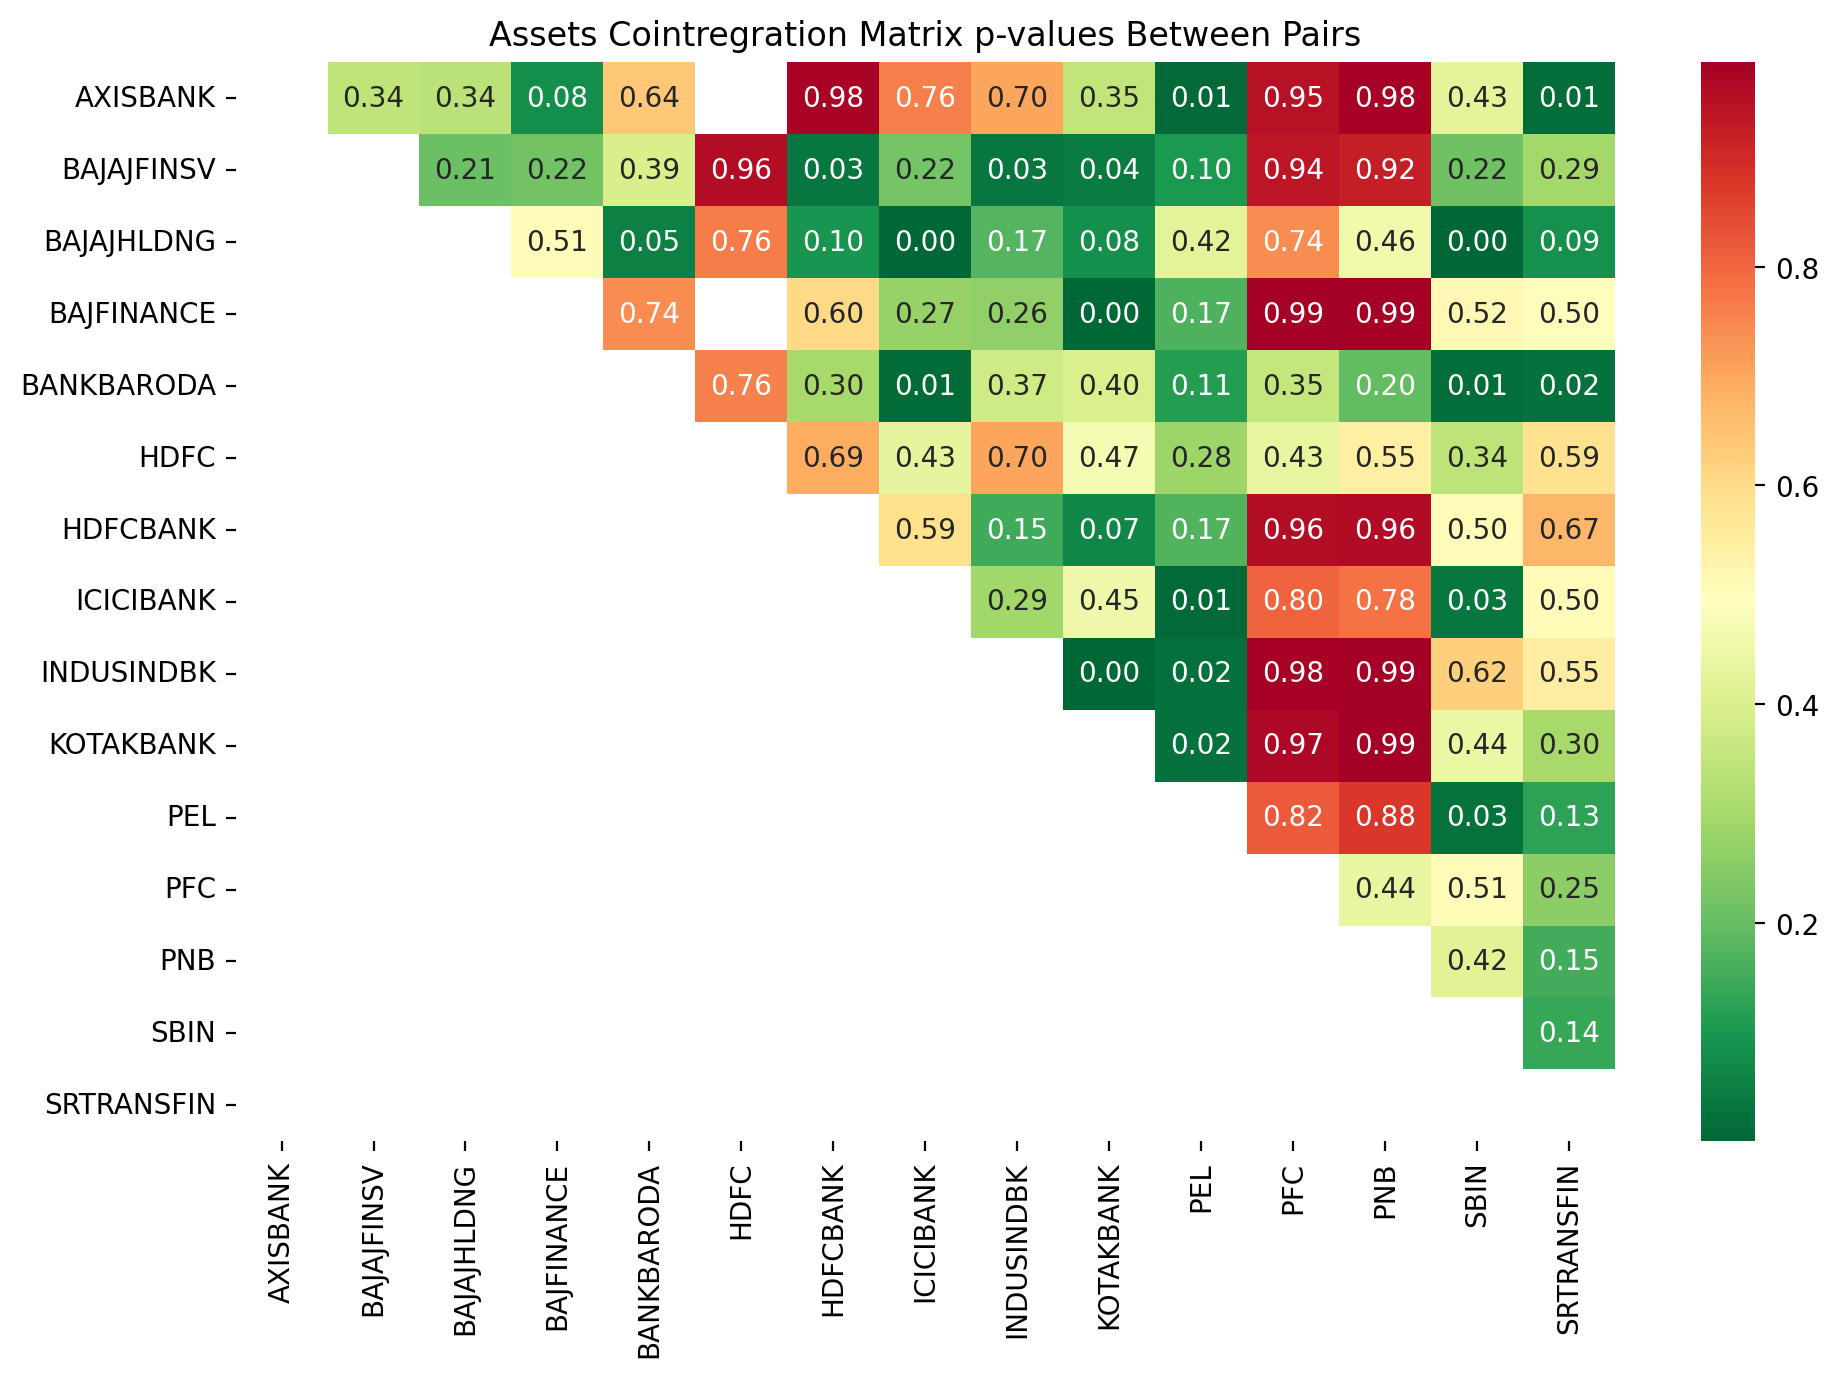

In [16]:
# рассчитываем p-значения и строим в виде тепловой карты
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns, yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

Давайте также проанализируем результат коинтеграционного теста. На приведенной выше
тепловой карте видно, что существует много пар со значением p менее 0,05. Это означает, что для
этих пар мы можем отвергнуть нулевую гипотезу и их можно коинтегрировать.

###################### Part 2 ##############################

Выполнение стационарного теста для выбранной пары

Теперь у нас есть много кандидатов в пары для стратегии, где p-значение меньше 0,05. Выбор
правильной пары имеет первостепенное значение, так как стратегия не будет работать, если цены
движутся точно вместе. Чтобы наша стратегия была прибыльной, они должны быть расходящимися и
означать возврат.
Давайте возьмем тикеры BANKBARODA и SBIN и дополнительно проверим стационарность спреда
с помощью расширенного теста Дики-Фуллера. Важно, чтобы спред был стационарным. Временной
ряд считается стационарным, если такие параметры, как среднее значение и дисперсия, не
меняются с течением времени и отсутствует единичный корень. Сначала мы рассчитаем коэффициент
хеджирования между этими двумя тикерами, используя регрессию МНК. Затем, используя коэффициент
хеджирования, мы рассчитаем спред и запустим расширенный тест Дики-Фуллера.

In [17]:
# последняя пара для тестирования
asset1 = 'BANKBARODA'
asset2 = 'SBIN'

In [18]:
# создаем фрейм данных поезда из 2 ассетов
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

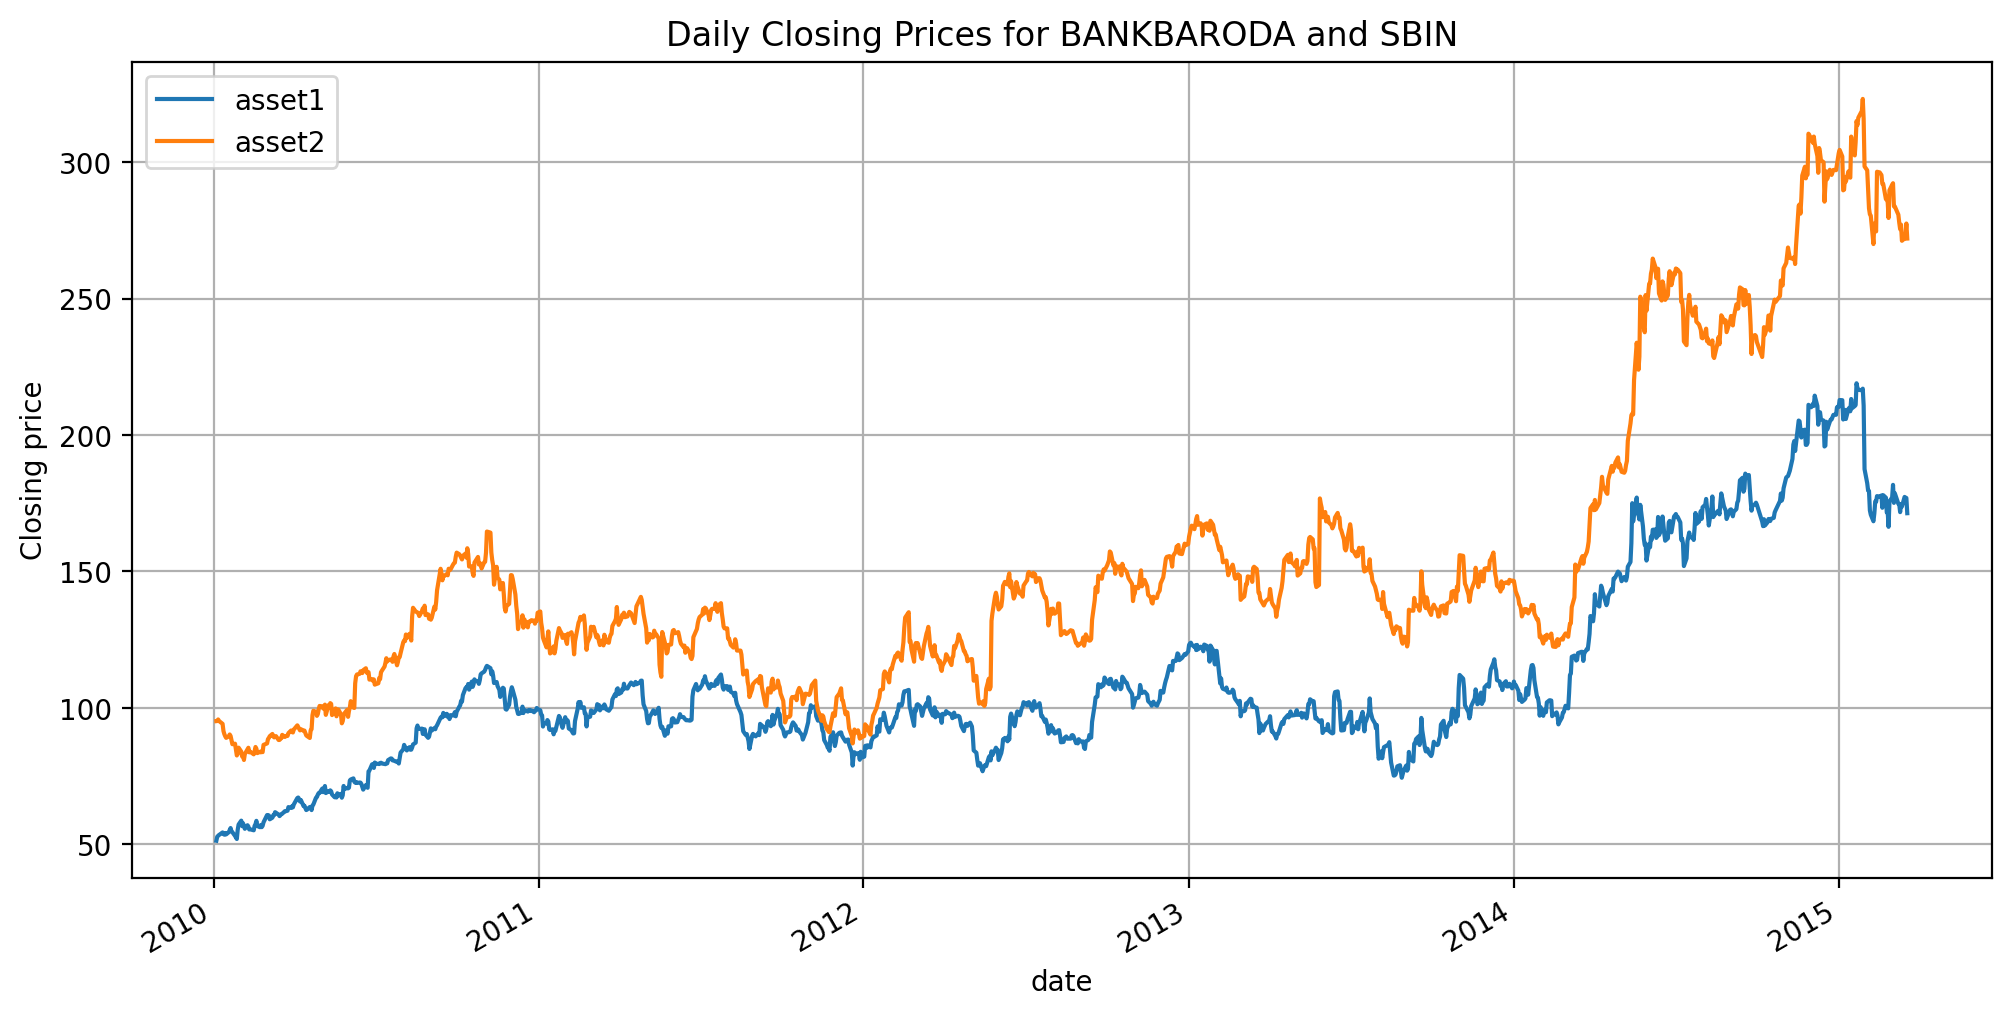

In [19]:
# визуализировать цены закрытия
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing price")
ax.grid(True)
plt.savefig('images/chart3.png', dpi = 300)

In [20]:
# запустить регрессионную
model = sm.OLS(train.asset2, train.asset1).fit()

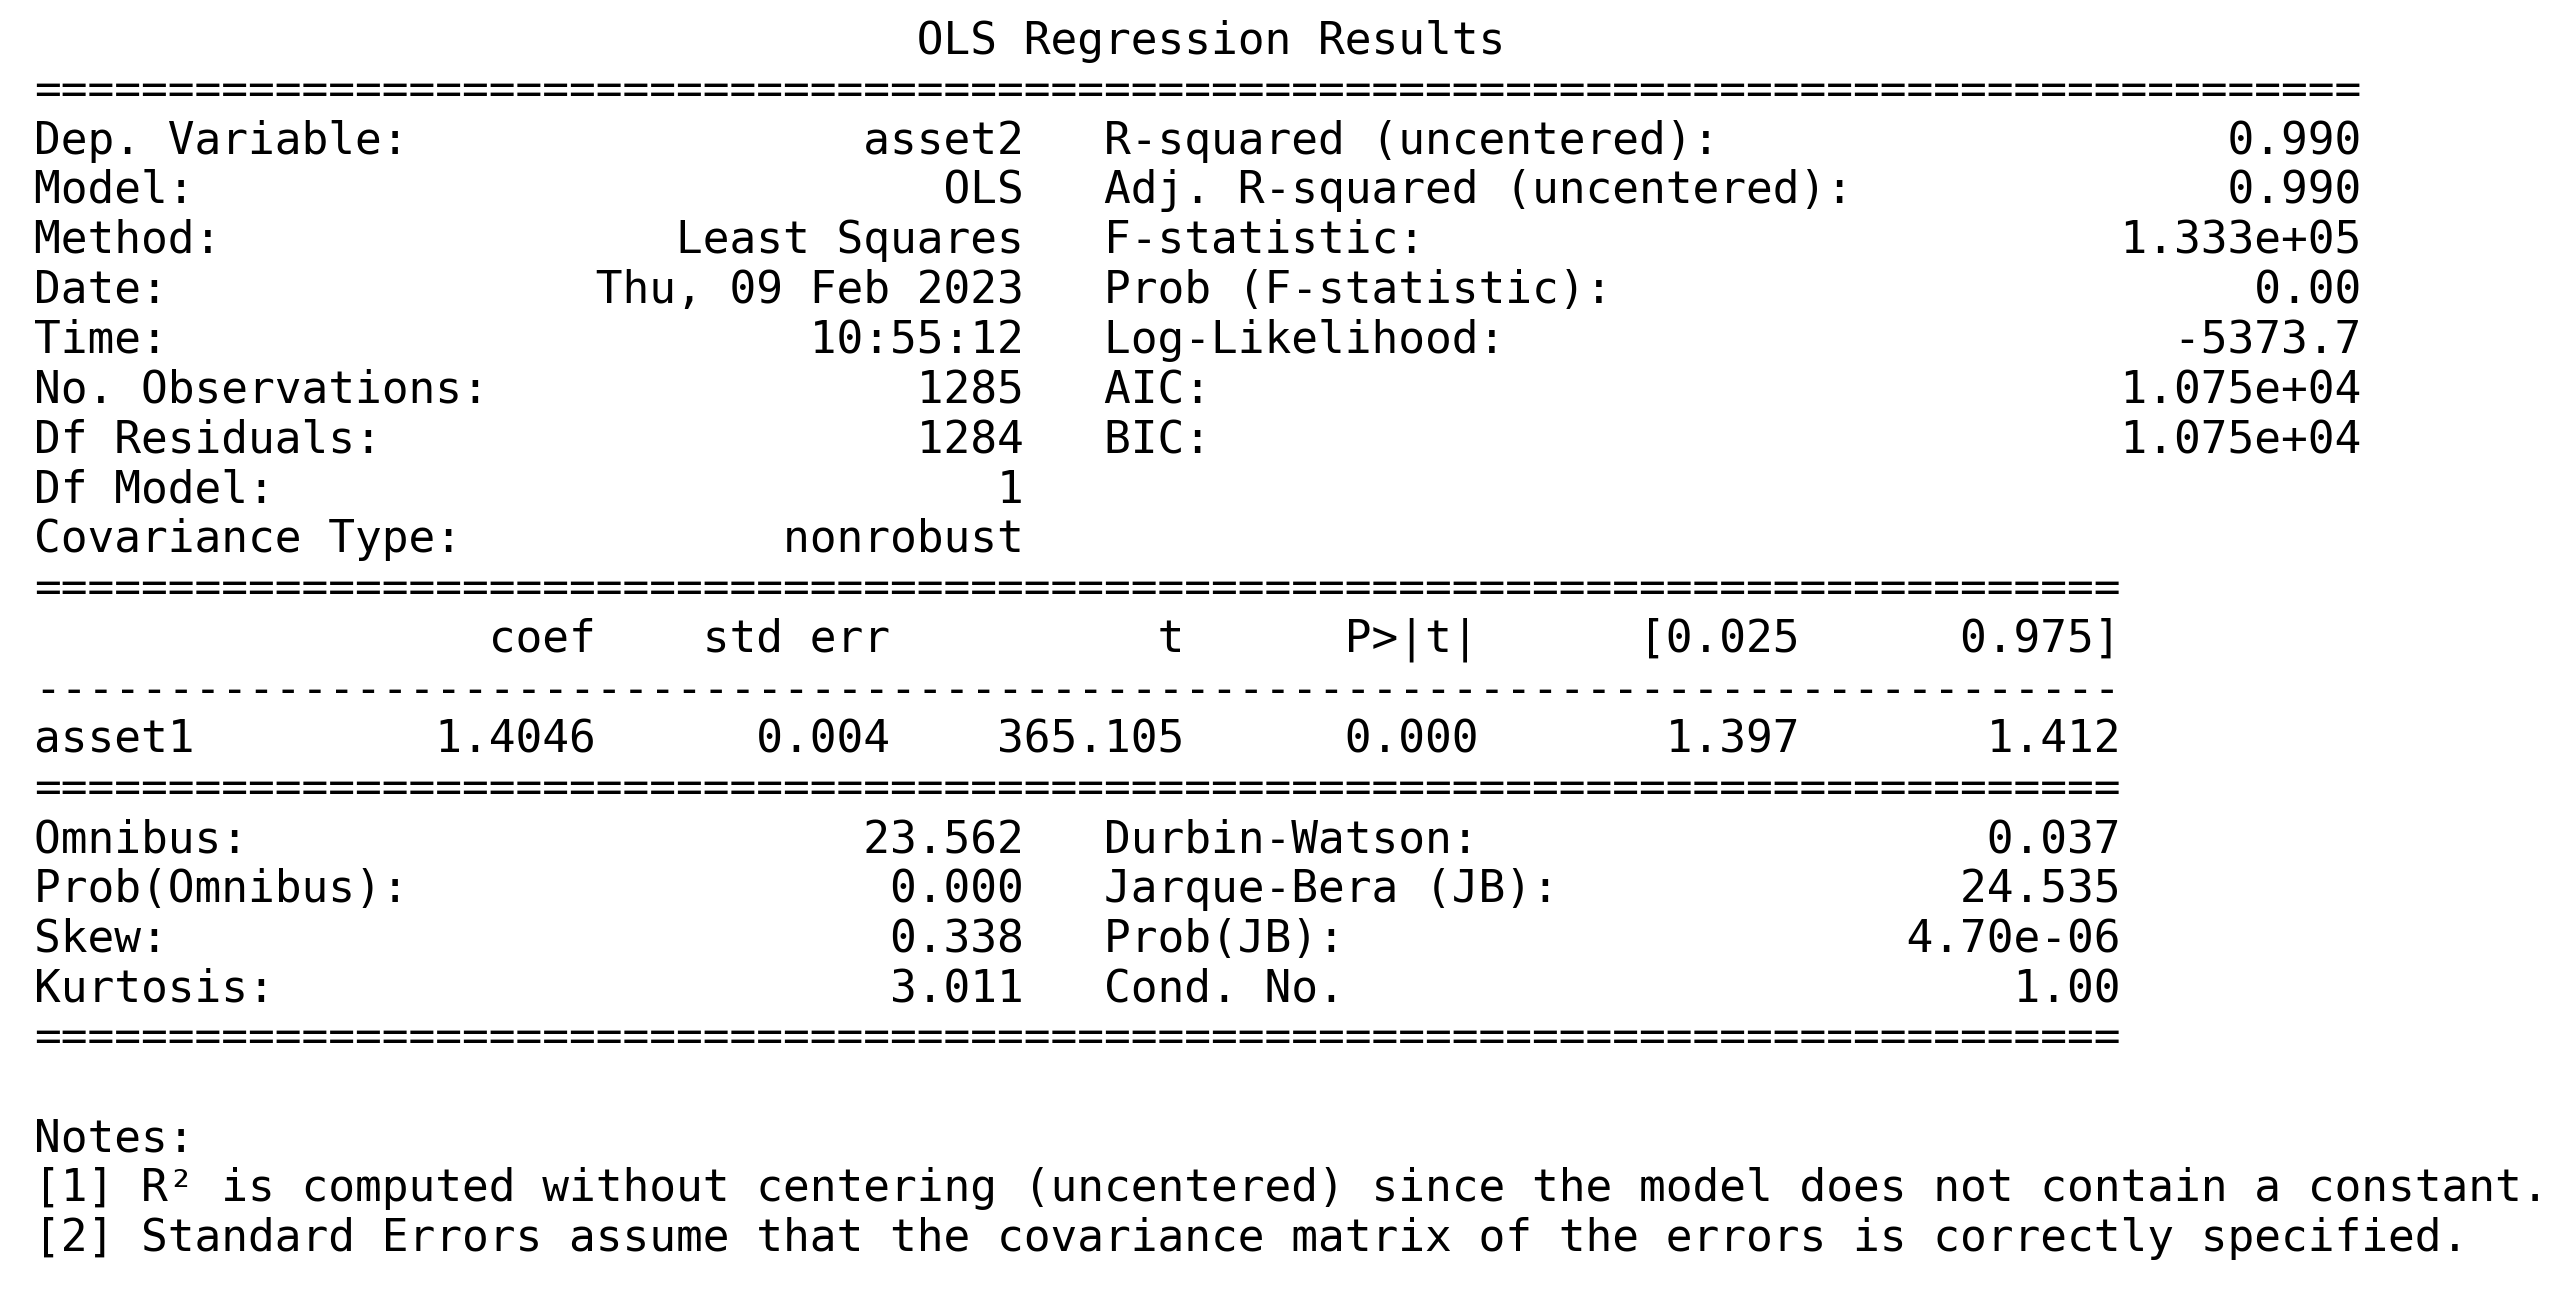

In [21]:
# вывести сводные результаты регрессии
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300)

Высокое значение R-квадрата и близкое к нулю p-значение из регрессии OLS предполагают очень высокую
корреляцию между этими двумя акциями. Разброс выглядит стационарным, а критическое значение
расширенного теста Дики-Фуллера составляет -3,459, что меньше значения при уровне значимости 1%
(-3,435). Следовательно, мы можем отвергнуть нулевую гипотезу о том, что распространение имеет
единичный корень, и можем заключить, что оно является стационарным в
природа.

In [22]:
print('Коэффициент хеджирования = ', model.params[0])

Коэффициент хеджирования =  1.4046459680586496


In [23]:
# рассчитать спред
spread = train.asset2 - model.params[0] * train.asset1

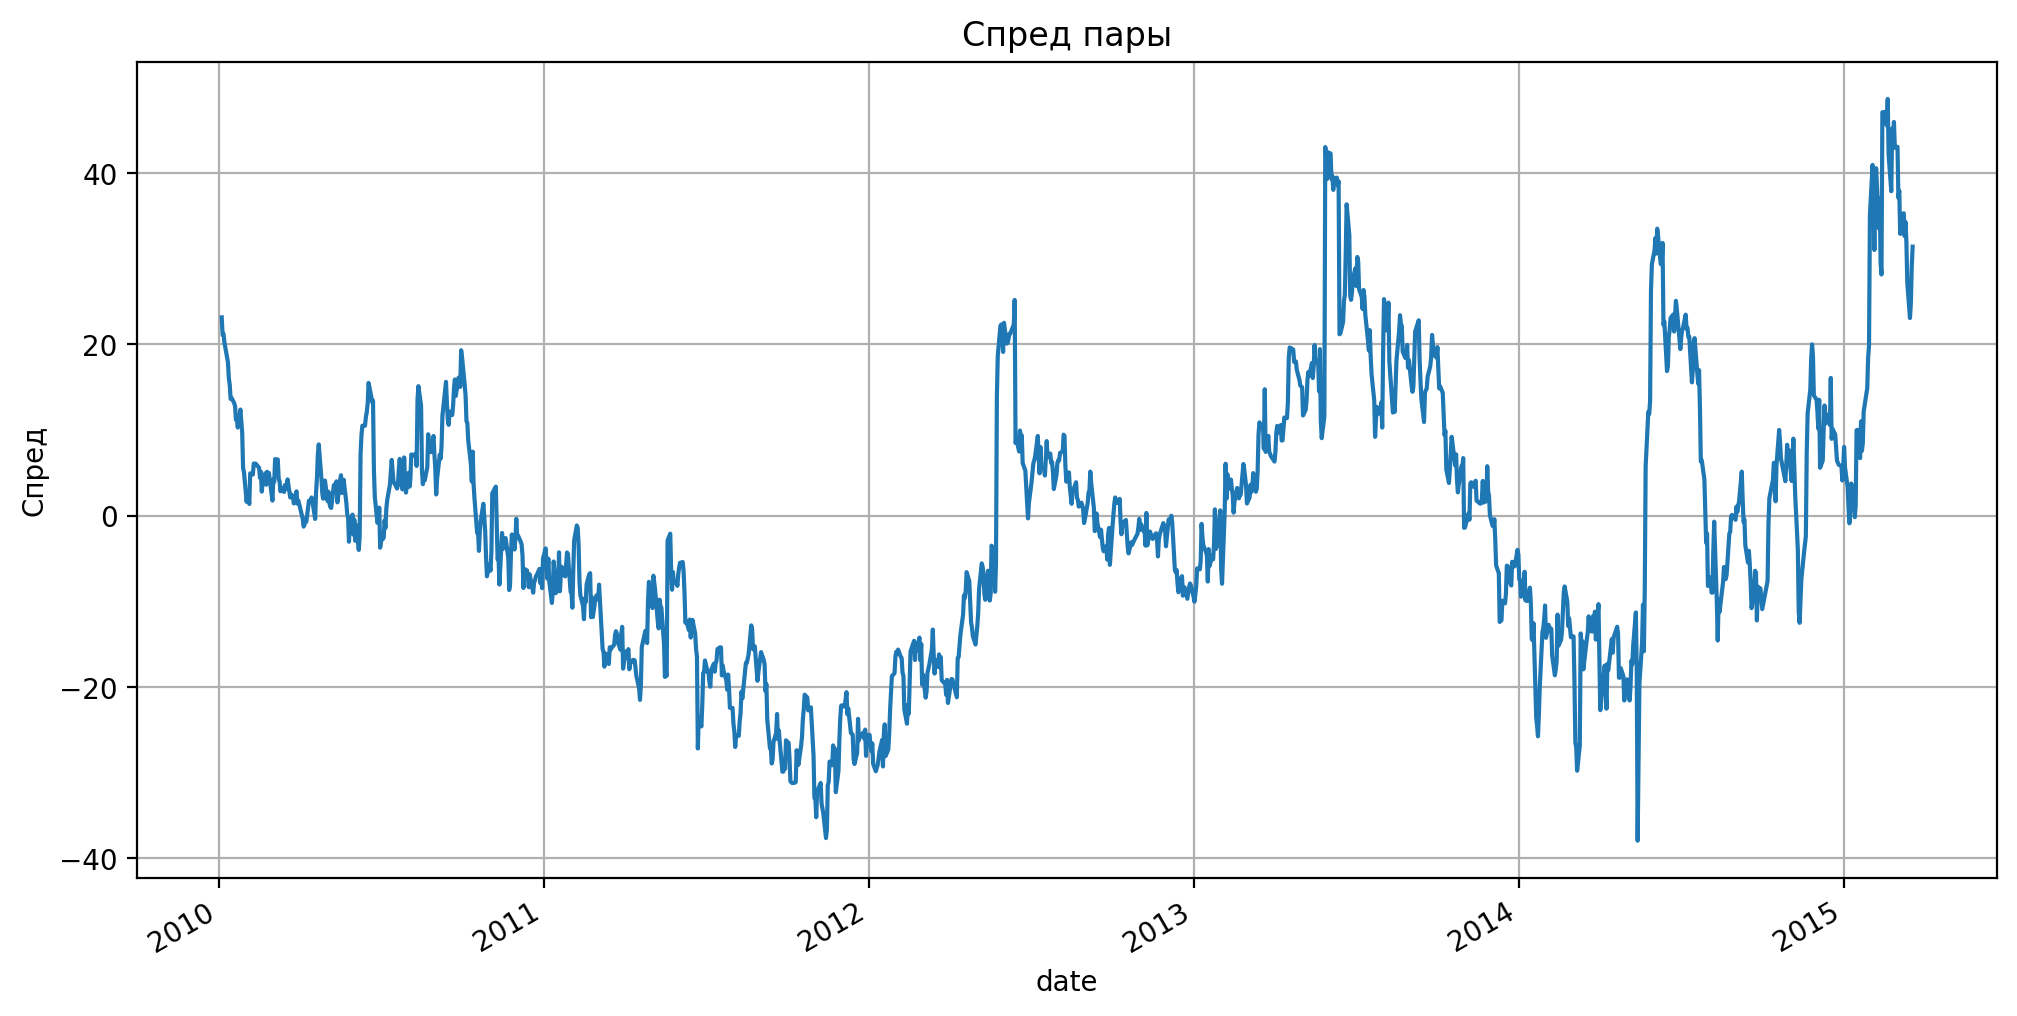

In [24]:
# Построить спред
ax = spread.plot(figsize=(12, 6), title = "Спред пары")
ax.set_ylabel("Спред")
ax.grid(True)
plt.savefig('images/chart5', dpi=300)

Из приведенного выше графика видно, что цены закрытия между этими двумя акциями движутся довольно
близко друг к другу.

In [25]:
# провести расширенный тест Дики-Фуллера
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.459047644292159


In [26]:
# критические значения вероятности
print(adf[4])

{'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}


Комментарий к коду:
1. Выберите актив1 как BANKBARODA и актив2 как SBIN.
2. Создайте фрейм данных цен закрытия двух вышеуказанных акций, используя обучающий набор
данных, и визуализируйте его.
3. Запустите регрессию МНК и получите коэффициент наклона, который также является нашим коэффициентом хеджирования.
4. Рассчитайте разброс и начертите его для визуализации.
5. Запустите расширенный тест Дики-Фуллера, чтобы проверить стационарность спреда и
наличие единичного корня.

###################### Part 3 ##############################

Сгенерируйте торговые сигналы, используя z-score


До этого момента мы использовали обучающий набор данных, чтобы завершить работу над парой
акций для нашей стратегии. Теперь мы будем использовать тестовый набор данных, чтобы убедиться,
что генерация торговых сигналов и обратное тестирование используют набор данных образца. Мы будем
использовать z-показатель отношения между двумя ценами акций для генерации торговых сигналов и
установки верхнего и нижнего порогов. Это покажет нам, насколько цена отличается от среднего значения
населения. Если он положительный и значение выше верхних порогов, то цена акции выше среднего
значения цены. Следовательно, ожидается, что его цена снизится, поэтому мы хотим открыть короткую
позицию (продать) эту акцию и купить (купить) другую.

In [27]:
# вычислить z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [28]:
# создаем фрейм данных для торговых сигналов
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1]
signals['asset2'] = test_close[asset2]
rations = signals.asset1 / signals.asset2

In [29]:
# рассчитать z-оценку и определить верхний и нижний пороги
signals['z'] = zscore(rations)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [30]:
# создать сигнал - короткий, если z-оценка больше верхнего предела, иначе длинный
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [31]:
# мы берем разницу первого порядка, чтобы получить позицию портфеля по этой акции
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

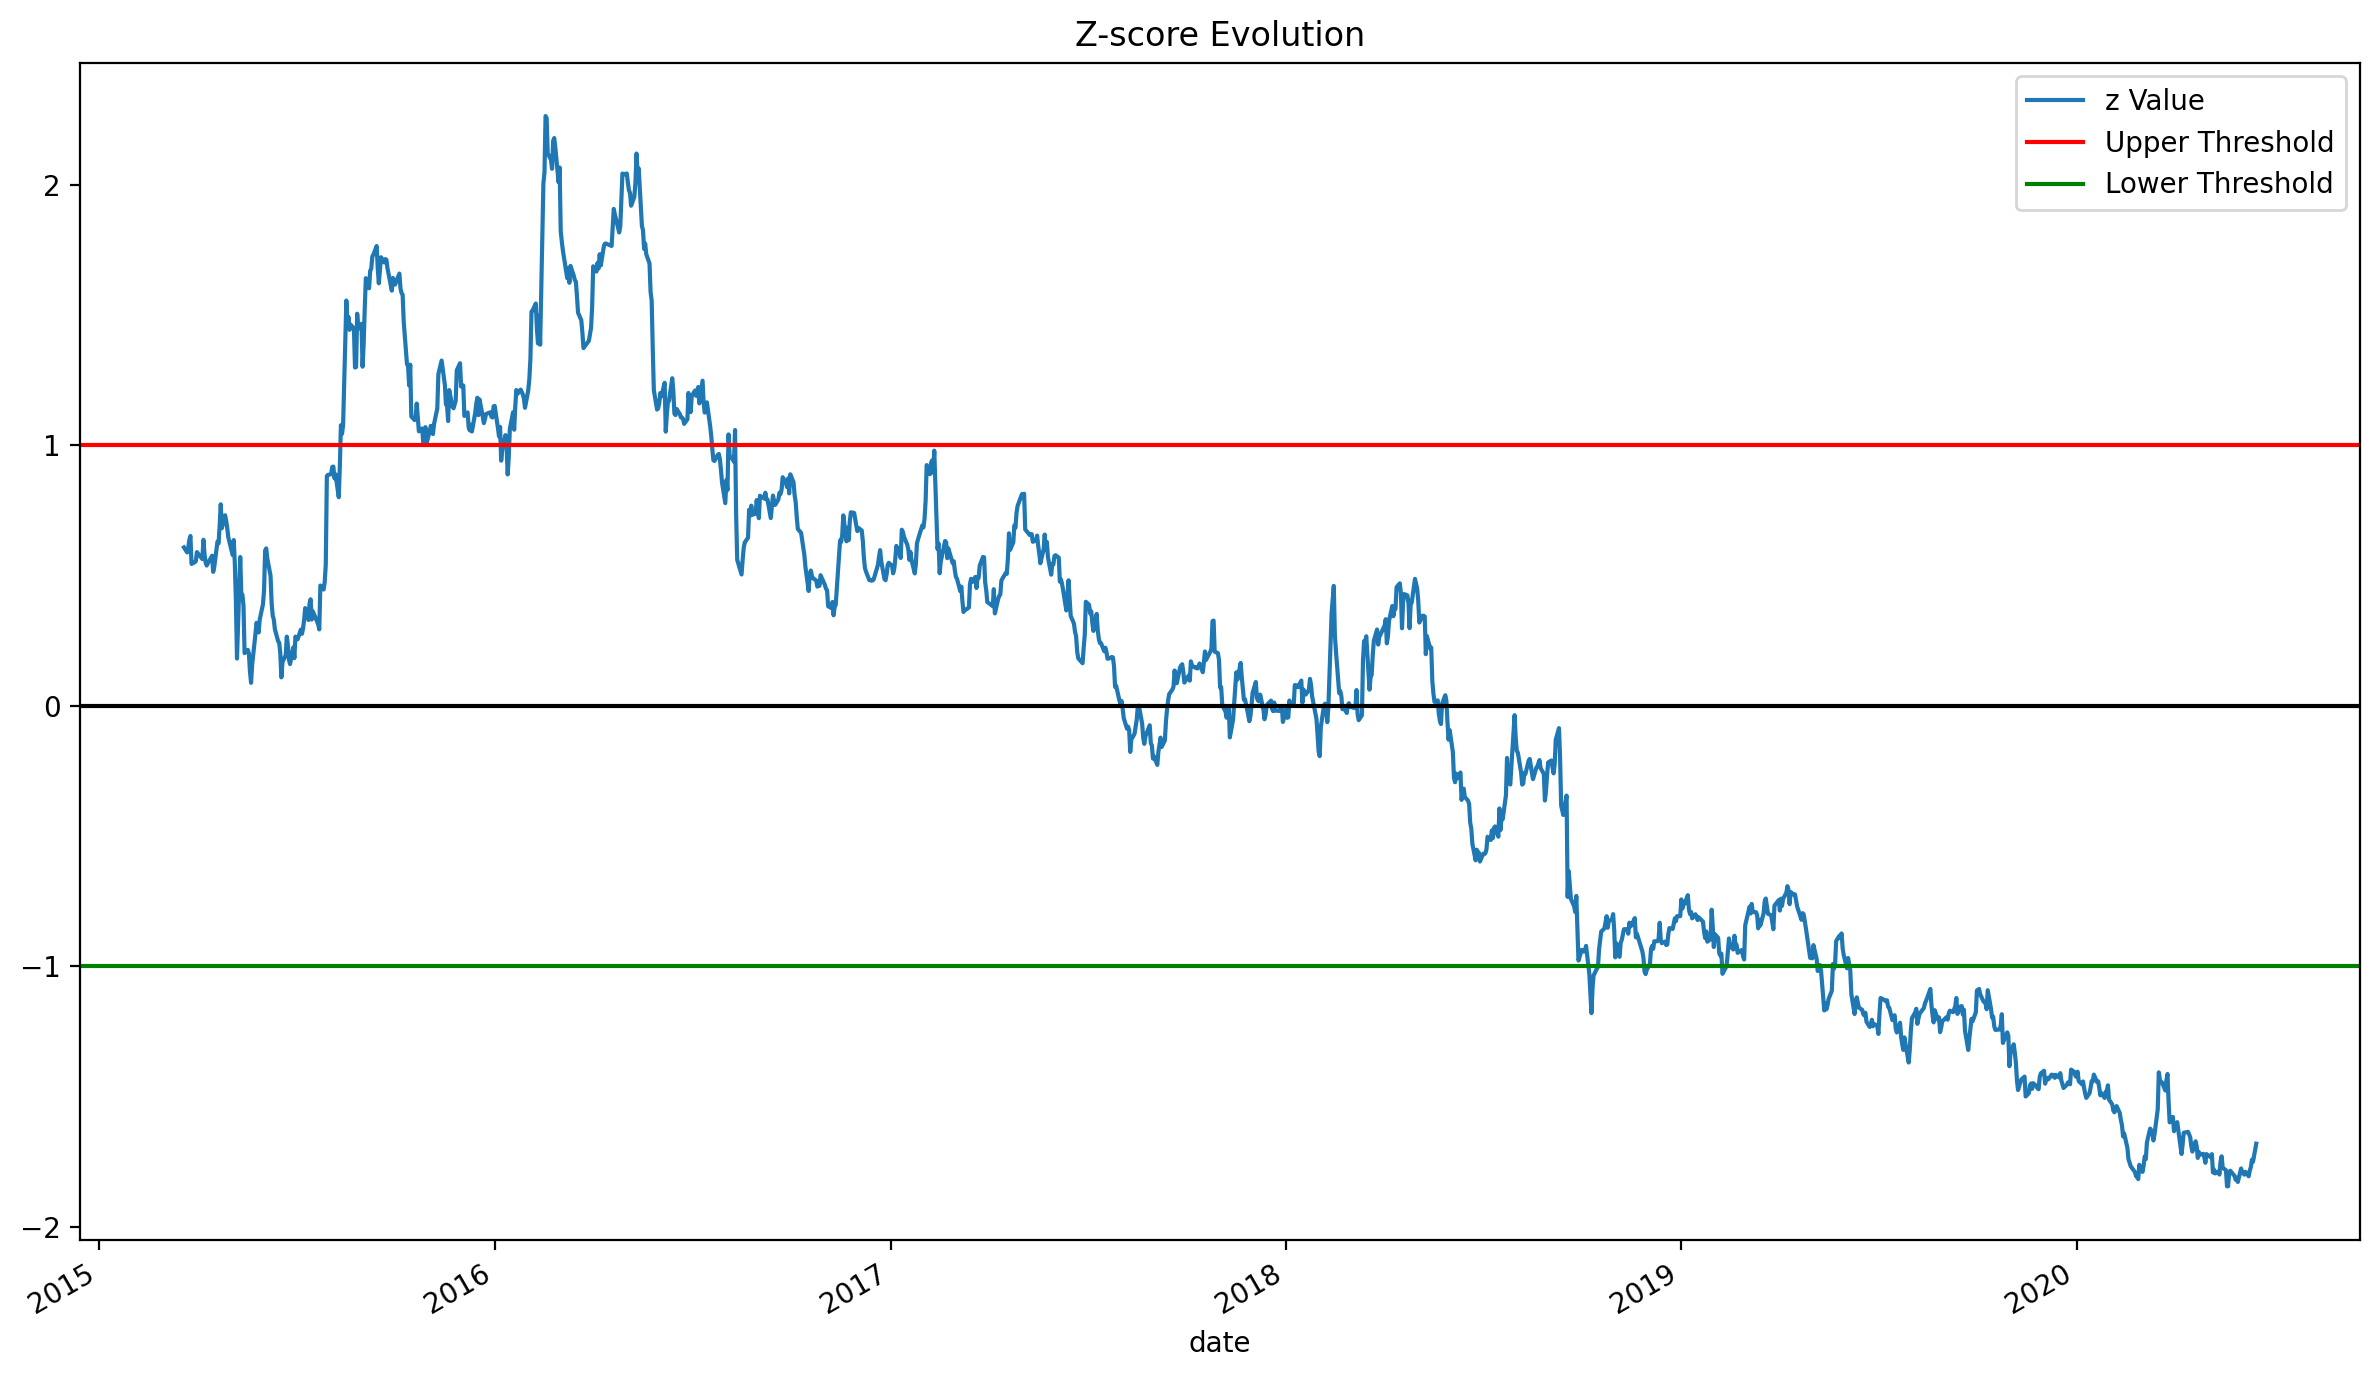

In [32]:
# # visualize z-score and upper and lower thresholds   
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evolution")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('images/chart6', dpi=300);

In [33]:
# проверить заголовок и хвост базы данных
signals.head(3).append(signals.tail(3))

/tmp/ipykernel_48802/4207653785.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-03-20,167.573654,268.787994,0.607914,1.0,-1.0,0,NaN,0,NaN
2015-03-23,164.661880,265.407043,0.588593,1.0,-1.0,0,0.0,0,0.0
2015-03-24,162.963318,261.349823,0.608571,1.0,-1.0,0,0.0,0,0.0
2020-06-11,45.150002,177.149994,-1.742935,1.0,-1.0,1,0.0,-1,0.0
2020-06-12,45.450001,179.149994,-1.750402,1.0,-1.0,1,0.0,-1,0.0
2020-06-15,45.950001,173.699997,-1.681271,1.0,-1.0,1,0.0,-1,0.0


In [34]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-08-12,174.784973,250.758850,1.077240,1.0,-1.0,-1,-1.0,1,1.0
2015-08-13,175.479935,253.644485,1.044138,1.0,-1.0,-1,0.0,1,0.0
2015-08-14,183.074966,262.643829,1.077383,1.0,-1.0,-1,0.0,1,0.0
2015-08-17,211.270905,273.648499,1.555787,1.0,-1.0,-1,0.0,1,0.0
2015-08-18,211.370178,278.588318,1.470744,1.0,-1.0,-1,0.0,1,0.0
2015-08-19,207.250000,271.936646,1.492476,1.0,-1.0,-1,0.0,1,0.0
2015-08-20,199.654968,264.649109,1.443286,1.0,-1.0,-1,0.0,1,0.0
2015-08-21,198.215378,261.665649,1.463059,1.0,-1.0,-1,0.0,1,0.0
2015-08-24,181.287903,240.047668,1.448404,1.0,-1.0,-1,0.0,1,0.0


In [35]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

/tmp/ipykernel_48802/2691838355.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())


,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-03-20,167.573654,268.787994,0.607914,1.0,-1.0,0,NaN,0,NaN
2015-08-12,174.784973,250.758850,1.077240,1.0,-1.0,-1,-1.0,1,1.0
2016-01-07,138.497604,204.979584,0.941009,1.0,-1.0,0,1.0,0,-1.0
2016-01-11,138.100479,199.844101,1.039079,1.0,-1.0,-1,-1.0,1,1.0
2016-01-12,133.533539,195.050964,0.998050,1.0,-1.0,0,1.0,0,-1.0
2019-05-22,126.150002,341.100006,-1.009666,1.0,-1.0,1,1.0,-1,-1.0
2019-05-23,127.550003,342.200012,-0.991154,1.0,-1.0,0,-1.0,0,1.0
2019-06-03,131.550003,355.450012,-1.007999,1.0,-1.0,1,1.0,-1,-1.0
2019-06-04,132.600006,352.399994,-0.968564,1.0,-1.0,0,-1.0,0,1.0


In [36]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

138.497604    1
133.533539    1
156.417908    1
156.517181    1
144.901260    1
97.500000     1
104.750000    1
104.900002    1
112.550003    1
113.650002    1
126.150002    1
131.550003    1
124.349998    1
Name: asset1, dtype: int64

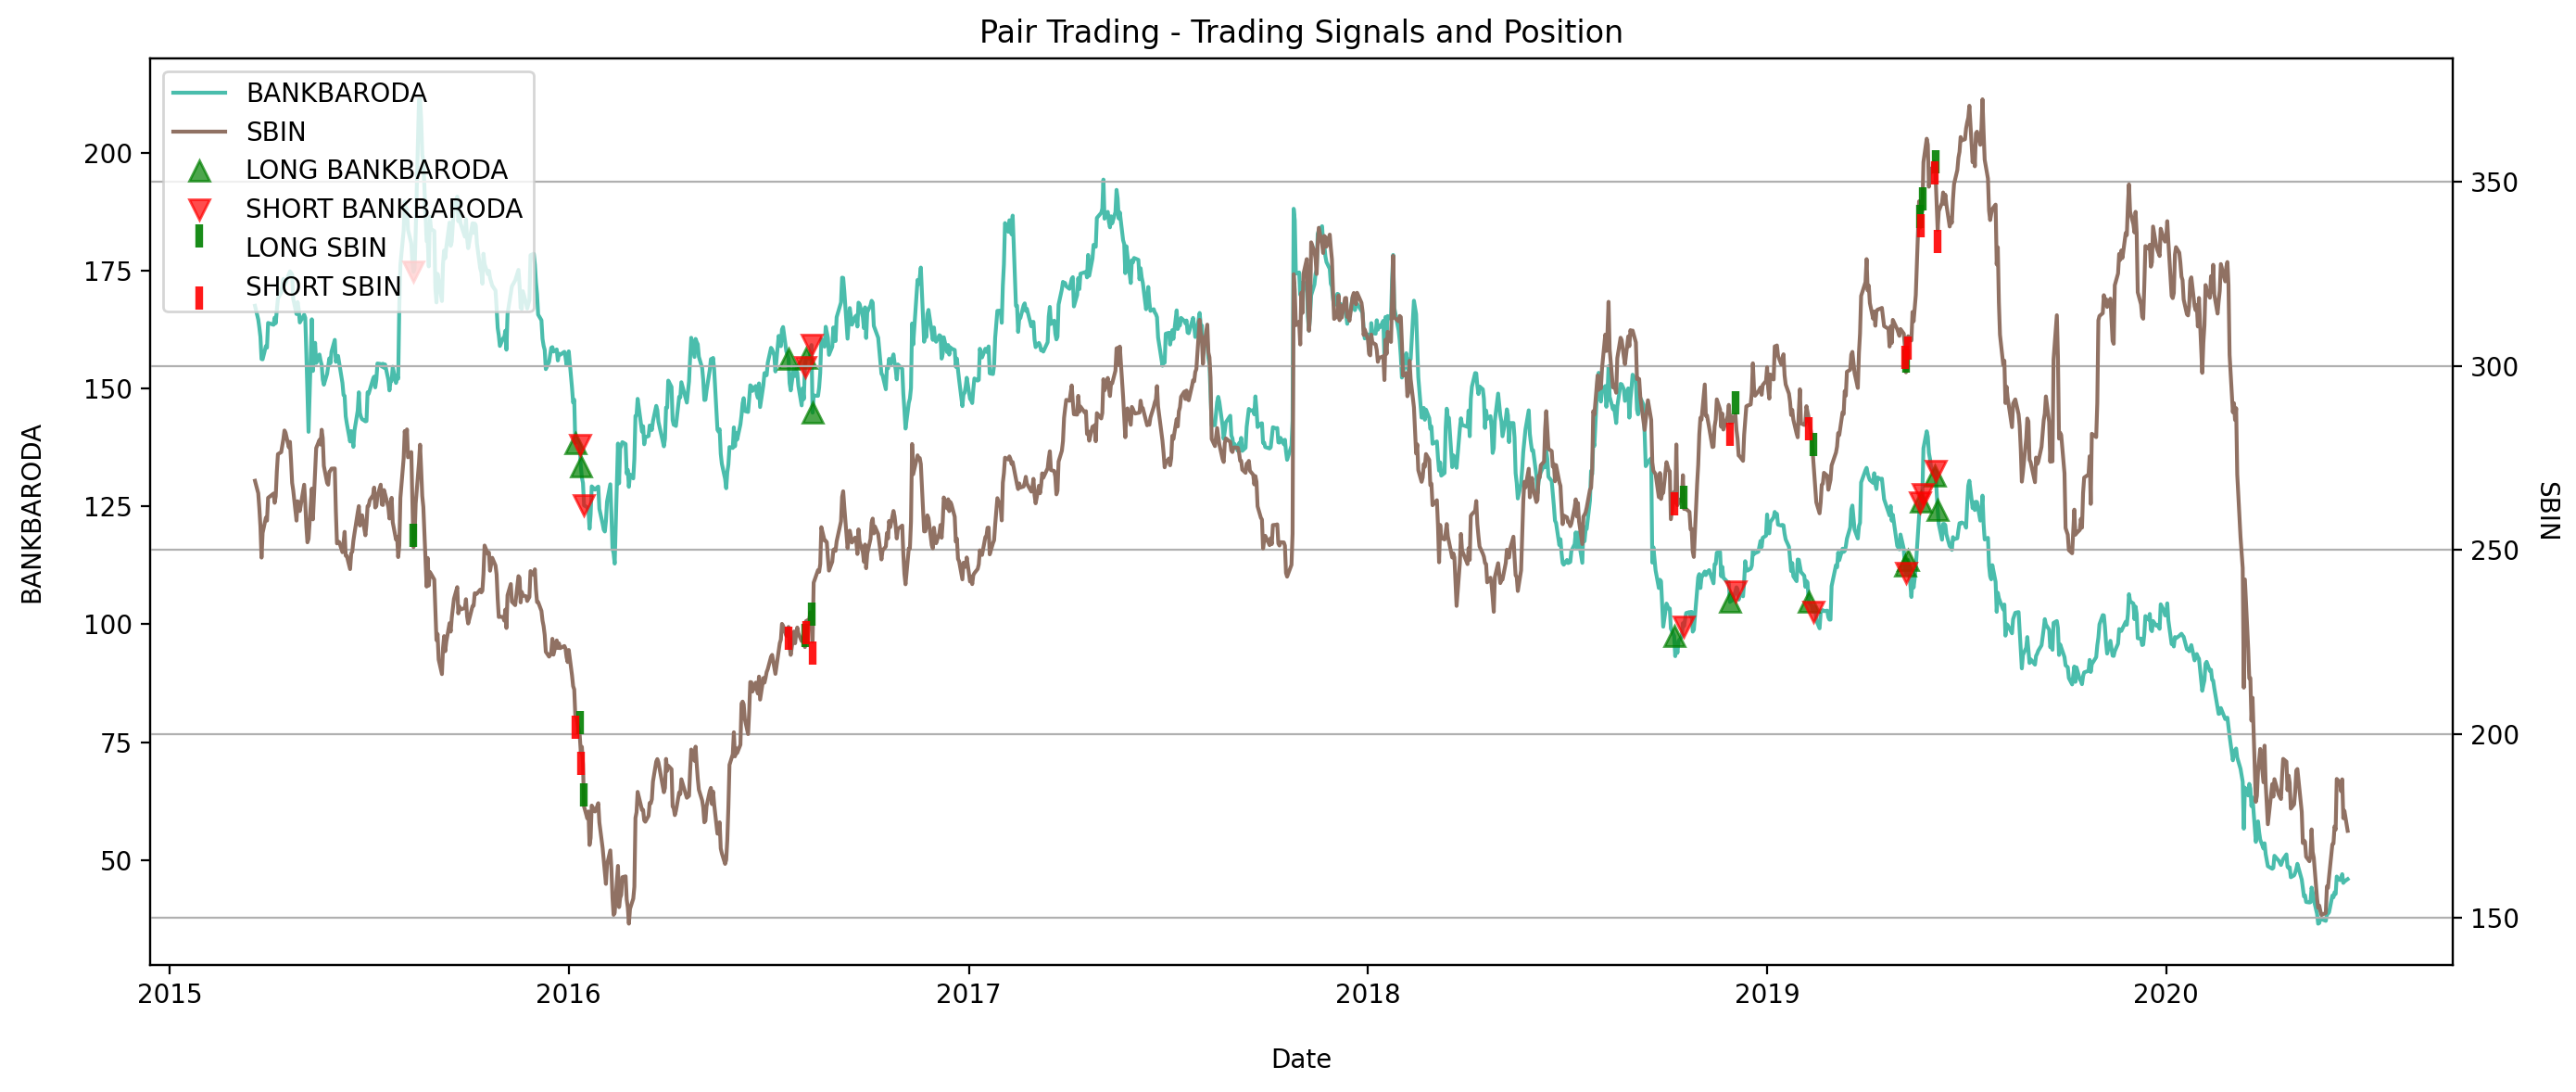

In [37]:
# визуализировать торговые сигналы и позицию
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
# построить два разных объекта
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/chart7', dpi=300);

Комментарий к коду:
1. Определите функцию zscore для вычисления z-score.
2. Создайте фрейм данных сигналов наших двух акций с ценой закрытия из
тестирование набора данных и расчет их ценового соотношения.
3. Рассчитайте z-показатель для отношения и определите верхний и нижний пороги с плюсом и минусом
одного стандартного отклонения.
4. Создайте столбец сигнала со следующей логикой — если z-оценка больше, чем
верхний порог, чем у нас будет -1 (короткий сигнал), однако, если z-оценка меньше нижнего порога, чем +1
(длинный сигнал), а значение по умолчанию равно нулю для отсутствия сигнала.
5. Возьмите разность первого порядка из сигнального столбца, чтобы получить позицию по акции.
Если он равен +1, то у нас длинная позиция, -1 — короткая и 0 — если позиции нет.
6. Второй сигнал будет прямо противоположен первому, что означает, что мы открываем длинную позицию
по одной акции и одновременно короткую по другой. Точно так же возьмите разность первого порядка для
второго сигнала и вычислите второй столбец позиции.
7. Затем мы визуализируем цены акций вместе с их длинными и короткими позициями в
портфолио.